In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 372.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=18186da4eed2d51dc0dd90d2cdfcefe70d376665b4d2d76945a37d9abbc86fa7
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [4]:

import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

In [5]:
ls

__notebook_source__.ipynb


In [6]:
GS_INPUT_DIR = "/kaggle/input/updatedre"
DATA_DIR = "/kaggle/working/"

# Base model used : "bert-base-cased"
BASE_MODEL_NAME = "bert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-json-re-v1".format(BASE_MODEL_NAME))

In [7]:
with open(os.path.join(GS_INPUT_DIR, "train.json"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2))

{
  "text": "#Causes - Dermatochalasis - 9A03.5\nDermatochalasis is due to age-related loss of skin elasticity and weakening of the connective tissue of the eyelid, usually seen in elderly. Pathophysiology. The pathophysiology of dermatochalasis is consistent with the normal ageing changes of the skin of eyelids. This includes loss of elastic fibers, thinning of the epidermis, and redundancy of the skin. Chronic infiltrate may be present when it is associated with dermatitis. Histologically, epidermis appears thin and smooth. Dermis shows some loss of elastic and collagen tissue, along with an increase of capillary vascularity. There is often basophilic degeneration of the collagen (actinic elastosis), and a mild lymphocytic inflammatory reaction. Systemic associations Systemic diseases which predispose patients to develop dermatochalasis are Thyroid eye disease. Hereditary angioneurotic oedema. Trauma. Renal disease. Amyloidosis. Cutis laxa. Ehlers-Danlos syndrome. Xanthelasma. Geneti

In [8]:
# counting frequency of the entities in train test and valid files

splits = ["train", "valid", "test"]

ent_counts = collections.defaultdict(collections.Counter)
for split in splits:
  cnt=1
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
#       print(split,cnt)
      cnt = cnt+1
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["entities"]:
        label = ent_mention["label"]
        ent_counts[label][split] += 1

ent_df = pd.DataFrame.from_dict(ent_counts, orient="index").sort_values("train", ascending=False)
ent_df
     

,train,valid,test
Disease_E,3800,1368,1251
Complication_E,1924,539,584
Symptom_E,1724,545,572
Cause_E,1422,498,446
Anatomy_E,1159,350,308
Medicine_E,1104,360,415
Diagnosis_E,1050,322,256
Precaution_E,630,193,205
Riskfactor_E,581,193,198
Surgery_E,318,139,101


In [9]:
# counting frequency of the entities in train test and valid files

rel_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["relations"]:
        label = ent_mention["type"].split("/")[-1]
        rel_counts[label][split] += 1

rel_df = pd.DataFrame.from_dict(rel_counts, orient="index").sort_values("train", ascending=False)
# rel_df = rel_df[(rel_df["lr-train"] > 1000) & (rel_df["lr-train"] < 10000)]
rel_df

,train,valid,test
has_symptom_R,1587,530.0,527
caused_by_R,1248,461.0,402
prescribed_for_R,970,314.0,354
has_complication_R,953,313.0,311
has_diagnosis_R,876,286.0,227
has_precaution_R,597,180.0,192
has_risk_factor_R,424,157.0,179
surgery_for_R,260,97.0,77
affects_R,213,94.0,75
influence_R,123,32.0,19


In [10]:

# id_to_text = {}
# def reformat_json(infile, outfile, valid_relations):
#   print("reformating {:s} -> {:s}".format(infile, outfile))
#   fout = open(outfile, "w")
#   with open(infile, "r") as fin:
#     for line in fin:
#       rec = json.loads(line.strip())
#       text = rec["text"]
#       print(text)
#       entities = {}
#       for entity_mention in rec["entities"]:
#         print(entity_mention)
#         entity_text = text[entity_mention["start_offset"]:entity_mention["end_offset"]]
#         print(entity_mention["start_offset"]," ",entity_mention["end_offset"])
# #         id_to_text[entity_mention["id"]] = entity_text
# #         entity_type = entity_mention["label"][0:3]
# #         entities[entity_text] = entity_type
#         print(entity_text)
        
        
# for i, split in enumerate(splits):
#   reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
#                 os.path.join(DATA_DIR, "{:s}.json".format(split)), 
#                 valid_relations=valid_relations)

In [11]:
# Creating the lines using sub to obj connection

id_to_text = {}
start_offset = {}
end_offset = {}
def reformat_json(infile, outfile, valid_relations):
  print("reformating {:s} -> {:s}".format(infile, outfile))
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin: 
      rec = json.loads(line.strip())
      text = rec["text"]
      entities = {}
      for entity_mention in rec["entities"]:
#         print("offset = ", entity_mention["start_offset"]," ",entity_mention["end_offset"])
        entity_text = text[entity_mention["start_offset"]:entity_mention["end_offset"]]
        id_to_text[entity_mention["id"]] = entity_text

        start_offset[entity_mention["id"]] = entity_mention["start_offset"]
        end_offset[entity_mention["id"]] = entity_mention["end_offset"]

        if entity_mention["label"] == "Composition":
            entity_type = entity_mention["label"][0:3]+"2"
        else:
            entity_type = entity_mention["label"][0:3]+"1"
        entities[entity_text] = entity_type.upper()
        # print(entities)
        # break
      for relation_mention in rec["relations"]:
        label = relation_mention["type"].split("/")[-1]
        if label not in valid_relations:
          continue
        try:
          from_id = relation_mention["from_id"]
          to_id = relation_mention["to_id"]
          if from_id>to_id:
            tmp = (to_id, from_id)
            from_id = tmp[0]
            to_id = tmp[1]
          
          sub_text = id_to_text[from_id]
          sub_type = entities[sub_text]
          # print(type(relation_mention["from_id"]),"-----------------------------")
#           print(from_id," ",relation_mention["to_id"])
          # print(sub_text,' -> ', relation_mention["from_id"], ' -> ', id_to_text[relation_mention["from_id"]], ' -> ', sub_type)
          obj_text = id_to_text[relation_mention["to_id"]]
          obj_type = entities[obj_text]
          # print(obj_text,' -> ', relation_mention["to_id"], ' -> ', id_to_text[relation_mention["to_id"]], ' -> ', obj_type)
          # print(sub_text," ",label," ",obj_text)
          # print(sub_type," ",label," ",obj_type)
          # assumption: em1Text == SUBJECT and occurs before em2Text == OBJECT

          sub_start = start_offset[from_id]
          obj_start = start_offset[to_id]
          sub_end = sub_start + len(sub_text)
          obj_end = obj_start + len(obj_text)

          if sub_start<obj_start:
#             print("sub ",sub_start," ------------------------------------ ",sub_end)
            text_pre = text[:sub_start]
            text_sub = " {:s} ".format(sub_type, sub_text, sub_type)
#             print(sub_text)
            
#             print("obj ",obj_start," ------------------------------------ ",obj_end)
            
            text_mid = text[sub_end:obj_start]
            text_obj = " {:s} ".format(obj_type, obj_text, obj_type)
#             print(obj_text)
            text_post = text[obj_end:]
            text = text_pre + text_sub + text_mid + text_obj + text_post
          else:
#             print("sub ",obj_start," ------------------------------------ ",obj_end)
            text_pre = text[:sub_start]
            text_obj = " {:s} ".format(obj_type, obj_text, obj_type)
#             print(obj_text)
            
            
#             print("obj ",sub_start," ------------------------------------ ",sub_end)
            
            text_mid = text[sub_end:obj_start]
            text_sub = " {:s} ".format(sub_type, sub_text, sub_type)
#             print(sub_text)
            text_post = text[obj_end:]
            text = text_pre + text_sub + text_mid + text_obj + text_post

#           print(text)
          tokens = text.split()
          output = {
              "tokens": tokens,
              "label": label
          }
          
          fout.write(json.dumps(output) + "\n")
        except:
          pass
  fout.close()


os.makedirs(DATA_DIR, exist_ok=True)

valid_relations = set([
  "affects_R", "caused_by_R", "has_code_R", "has_diagnosis_R", "has_precaution_R",
  "has_risk_factor_R", "has_symptom_R", "made_with_R", "prescribed_for_R", "has_complication_R", 
  "influence_R", "has_side_effect_R", "surgery_on_R", "diagnosis_on_R", "needs_R", "surgery_for_R"
])

for i, split in enumerate(splits):
  reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)), 
                valid_relations=valid_relations)
  

reformating /kaggle/input/updatedre/train.json -> /kaggle/working/train.json
reformating /kaggle/input/updatedre/valid.json -> /kaggle/working/valid.json
reformating /kaggle/input/updatedre/test.json -> /kaggle/working/test.json


In [12]:
splits = ["train", "valid", "test"]
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
print(data_files)
json_dataset = load_dataset("json", data_files=data_files)
json_dataset
     

{'train': '/kaggle/working/train.json', 'valid': '/kaggle/working/valid.json', 'test': '/kaggle/working/test.json'}


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-a4939474331cd02d/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 7455
    })
    valid: Dataset({
        features: ['tokens', 'label'],
        num_rows: 2525
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 2451
    })
})

In [13]:
print(json_dataset['train'][20])

{'tokens': ['#Complications', '-', 'DIS1', '-', '9A03.5', 'Complications', 'of', 'dermatochalasis', 'may', 'be', 'Lagophthalmos.', 'Ptosis.', 'Keratitis.', 'COM1', '.', 'Conjunctival', 'chemosis.'], 'label': 'has_complication_R'}


In [14]:
json_dataset.set_format(type="pandas")
json_df = json_dataset["train"][:]
json_df.head()

,tokens,label
0,"[#Causes, -, Dermatochalasis, -, 9A03.5, DIS1,...",caused_by_R
1,"[#Causes, -, Dermatochalasis, -, 9A03.5, DIS1,...",caused_by_R
2,"[#Causes, -, Dermatochalasis, -, 9A03.5, DIS1,...",caused_by_R
3,"[#Causes, -, DIS1, -, 9A03.5, DIS1, and, weake...",caused_by_R
4,"[#Causes, -, DIS1, DIS1, and, weakening, of, t...",caused_by_R


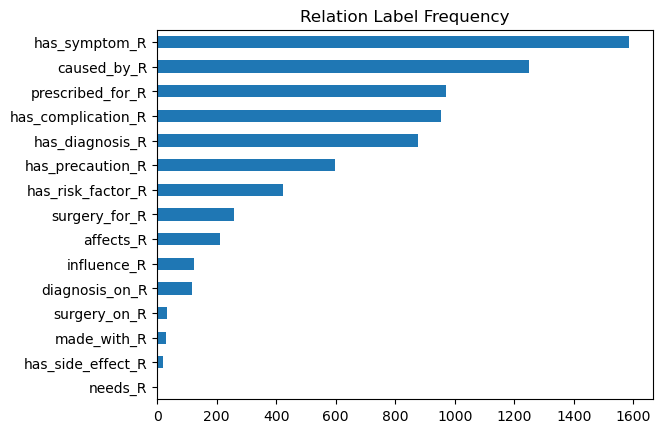

In [15]:
json_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

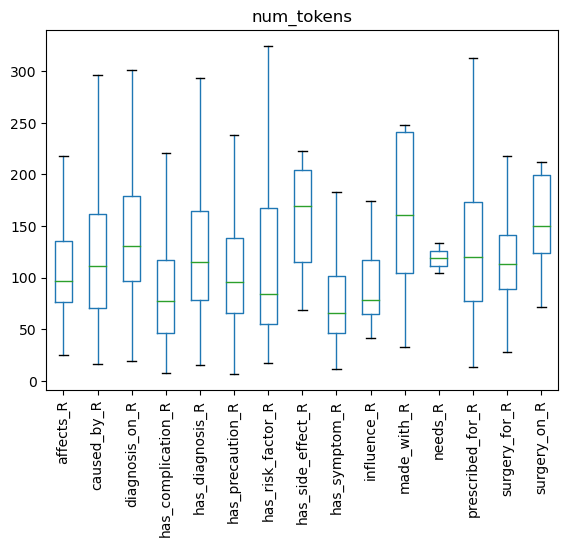

In [16]:

json_df["num_tokens"] = json_df["tokens"].apply(len)
json_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [17]:
json_dataset.reset_format()


In [18]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)
vocab_size_orig = len(tokenizer.vocab)

In [19]:

marker_tokens = []
entity_types = ["DIS1","ANA1","CAU1","COD1","DIA1","PRE1","RIS1","SYM1","MED1","COM1","COM2","SUR1"]
for entity_type in entity_types:
  print(entity_type, end = " -> ")
  marker_tokens.append("".format(entity_type))
  marker_tokens.append("".format(entity_type))
  marker_tokens.append("".format(entity_type))
  marker_tokens.append("".format(entity_type))
  print(marker_tokens)

tokenizer.add_tokens(marker_tokens)
vocab_size_new = len(tokenizer.vocab)

print("original vocab size:", vocab_size_orig)
print("new vocab size:", vocab_size_new)


DIS1 -> ['', '', '', '']
ANA1 -> ['', '', '', '', '', '', '', '']
CAU1 -> ['', '', '', '', '', '', '', '', '', '', '', '']
COD1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
DIA1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
PRE1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
RIS1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
SYM1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
MED1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
COM1 -> ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
COM2 -> ['', '', '', '', '', '

In [20]:
valid_relations = sorted(list(valid_relations))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}

# label2id, id2label
print(label2id)
fg=True

{'affects_R': 0, 'caused_by_R': 1, 'diagnosis_on_R': 2, 'has_code_R': 3, 'has_complication_R': 4, 'has_diagnosis_R': 5, 'has_precaution_R': 6, 'has_risk_factor_R': 7, 'has_side_effect_R': 8, 'has_symptom_R': 9, 'influence_R': 10, 'made_with_R': 11, 'needs_R': 12, 'prescribed_for_R': 13, 'surgery_for_R': 14, 'surgery_on_R': 15}


In [21]:

def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    
    span_idxs.append([
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0]
    ])
    
#     print(tokenized_inputs)
#     print("input ids: ")
#     print(input_id)
#     print("convert ids to tokens: ")
#     print(tokens)
#     print("span indexes")
#     print(span_idxs)
#     break
        
    
  tokenized_inputs["span_idxs"] = span_idxs
  tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs
encoded = encode_data(json_dataset["train"][0:5])
encoded.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'])

In [22]:

MAX_LENGTH = 100
encoded_json_dataset = (json_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))


  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [23]:
print("converted text: ")
print(tokenizer.convert_ids_to_tokens(encoded_json_dataset['train']['input_ids'][0]))
print("input ids: ")
print(encoded_json_dataset['train']['input_ids'][0])
print("token type ids: ")
print(encoded_json_dataset['train']['token_type_ids'][0])
print("attention_mask: ")
print(encoded_json_dataset['train']['attention_mask'][0])
print("span idxs: ")
print(encoded_json_dataset['train']['span_idxs'][0])
print("label: ")
print(encoded_json_dataset['train']['labels'][0])


converted text: 
['[CLS]', '#', 'Co', '##mp', '##lication', '##s', '-', 'D', '##IS', '##1', '-', '9', '##A', '##0', '##3', '.', '5', 'Co', '##mp', '##lication', '##s', 'of', 'der', '##mat', '##och', '##ala', '##sis', 'may', 'be', 'La', '##go', '##ph', '##thal', '##mos', '.', 'P', '##tosis', '.', 'Ke', '##rat', '##itis', '.', 'CO', '##M', '##1', '.', 'Con', '##junct', '##ival', 'ch', '##em', '##osis', '.', '[SEP]']
input ids: 
[101, 108, 3291, 8223, 20721, 1116, 118, 141, 6258, 1475, 118, 130, 1592, 1568, 1495, 119, 126, 3291, 8223, 20721, 1116, 1104, 4167, 21943, 9962, 5971, 4863, 1336, 1129, 2001, 2758, 7880, 17939, 11828, 119, 153, 26156, 119, 26835, 7625, 10721, 119, 18732, 2107, 1475, 119, 16752, 20327, 15895, 22572, 5521, 11776, 119, 102]
token type ids: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [24]:
encoded_json_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3964
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 1558
    })
})

In [25]:
# BATCH_SIZE = 16   
BATCH_SIZE = 1   

collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_json_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_json_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_json_dataset["valid"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_json_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_json_dataset["test"], 
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_json_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

In [26]:
print(train_dl)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
class BertForRelationExtraction(BertPreTrainedModel):
  def __init__(self, config, num_labels):
    super(BertForRelationExtraction, self).__init__(config)
    self.num_labels = num_labels
    # body
    self.bert = BertModel(config)
    # head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    self.init_weights()

  def forward(self, input_ids, token_type_ids, attention_mask,
              span_idxs, labels=None):
    outputs = (
        self.bert(input_ids, token_type_ids=token_type_ids,
                  attention_mask=attention_mask,
                  output_hidden_states=False)
            .last_hidden_state)
            
    sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      # span excludes entity markers, maxpool across span
      sub_span = torch.max(outputs[bid, span_idxs[bid, 0]:span_idxs[bid, 1]+1, :], 
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, span_idxs[bid, 2]:span_idxs[bid, 3]+1, :],
                           dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)

    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    rel_input = torch.cat((sub_emb, obj_emb), dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


In [29]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3
BASE_MODEL_NAME = "bert-base-cased"

config = BertConfig.from_pretrained(BASE_MODEL_NAME)
model = BertForRelationExtraction.from_pretrained(BASE_MODEL_NAME, 
                                                  config=config,
                                                  num_labels=len(valid_relations))
model.bert.resize_token_embeddings(len(tokenizer.vocab))
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForRelationExtraction: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForRelationExtraction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForRelationExtraction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForRelationExtraction were not initialized from the model checkpoint at bert-base-cased a

In [30]:
def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
  return train_loss

def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
    loss = outputs.loss
    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_accuracy(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score

def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))

def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()


In [31]:

if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)
     

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


EPOCH 1, train loss: 2747.853, val loss: 747.359, val-acc: 0.84270
EPOCH 2, train loss: 1758.546, val loss: 1100.929, val-acc: 0.81617
EPOCH 3, train loss: 1470.077, val loss: 527.223, val-acc: 0.86797


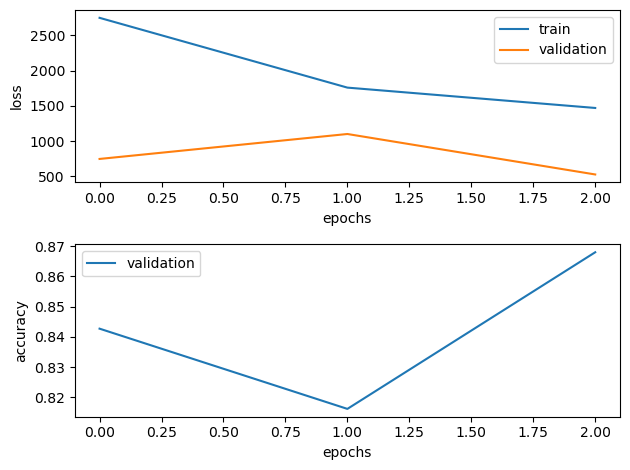

In [32]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

In [33]:
ytrue, ypred = [], []
for batch in test_dl:
#     print(batch)
#     print("----------------- end batch")
    batch = {k: v.to(device) for k, v in batch.items()}
#     print(batch)
#     print("----------------- end batch 2")
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
#       print(predictions)
#       print("----------------- predictions")
      labels = batch["labels"].cpu().numpy()
      ytrue.extend(labels)
      ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

test accuracy: 0.871


In [34]:
print(test_dl)

In [35]:
mylist = json_df["label"]
mylist = list(dict.fromkeys(mylist))
print(mylist)

['caused_by_R', 'has_complication_R', 'affects_R', 'has_diagnosis_R', 'has_symptom_R', 'has_precaution_R', 'prescribed_for_R', 'surgery_for_R', 'has_risk_factor_R', 'diagnosis_on_R', 'influence_R', 'made_with_R', 'surgery_on_R', 'has_side_effect_R', 'needs_R']


In [36]:
ml = ['caused_by_R', 'has_complication_R', 'affects_R', 'has_diagnosis_R', 'has_symptom_R', 'has_precaution_R', 'prescribed_for_R', 'surgery_for_R', 'has_risk_factor_R', 'diagnosis_on_R', 'influence_R', 'made_with_R','surgery_on_R', 'has_side_effect_R']

#@title Default title text

print(classification_report(ytrue, ypred, target_names=ml))
# print(classification_report(ytrue, ypred, labels=['has_complication_R', 'affects_R', 'has_diagnosis_R', 'has_symptom_R', 'has_precaution_R', 'prescribed_for_R', 'surgery_for_R']))

                    precision    recall  f1-score   support

       caused_by_R       0.54      0.50      0.52        38
has_complication_R       0.86      0.94      0.90       224
         affects_R       0.25      0.05      0.08        21
   has_diagnosis_R       0.93      0.80      0.86       222
     has_symptom_R       0.77      0.98      0.86       137
  has_precaution_R       0.97      0.97      0.97       115
  prescribed_for_R       0.90      0.89      0.90       112
     surgery_for_R       0.00      0.00      0.00         6
 has_risk_factor_R       0.95      0.97      0.96       406
    diagnosis_on_R       0.17      0.07      0.10        14
       influence_R       0.00      0.00      0.00        12
       made_with_R       0.85      0.93      0.89       218
      surgery_on_R       0.23      0.21      0.22        28
 has_side_effect_R       0.00      0.00      0.00         5

          accuracy                           0.87      1558
         macro avg       0.53      0.5

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


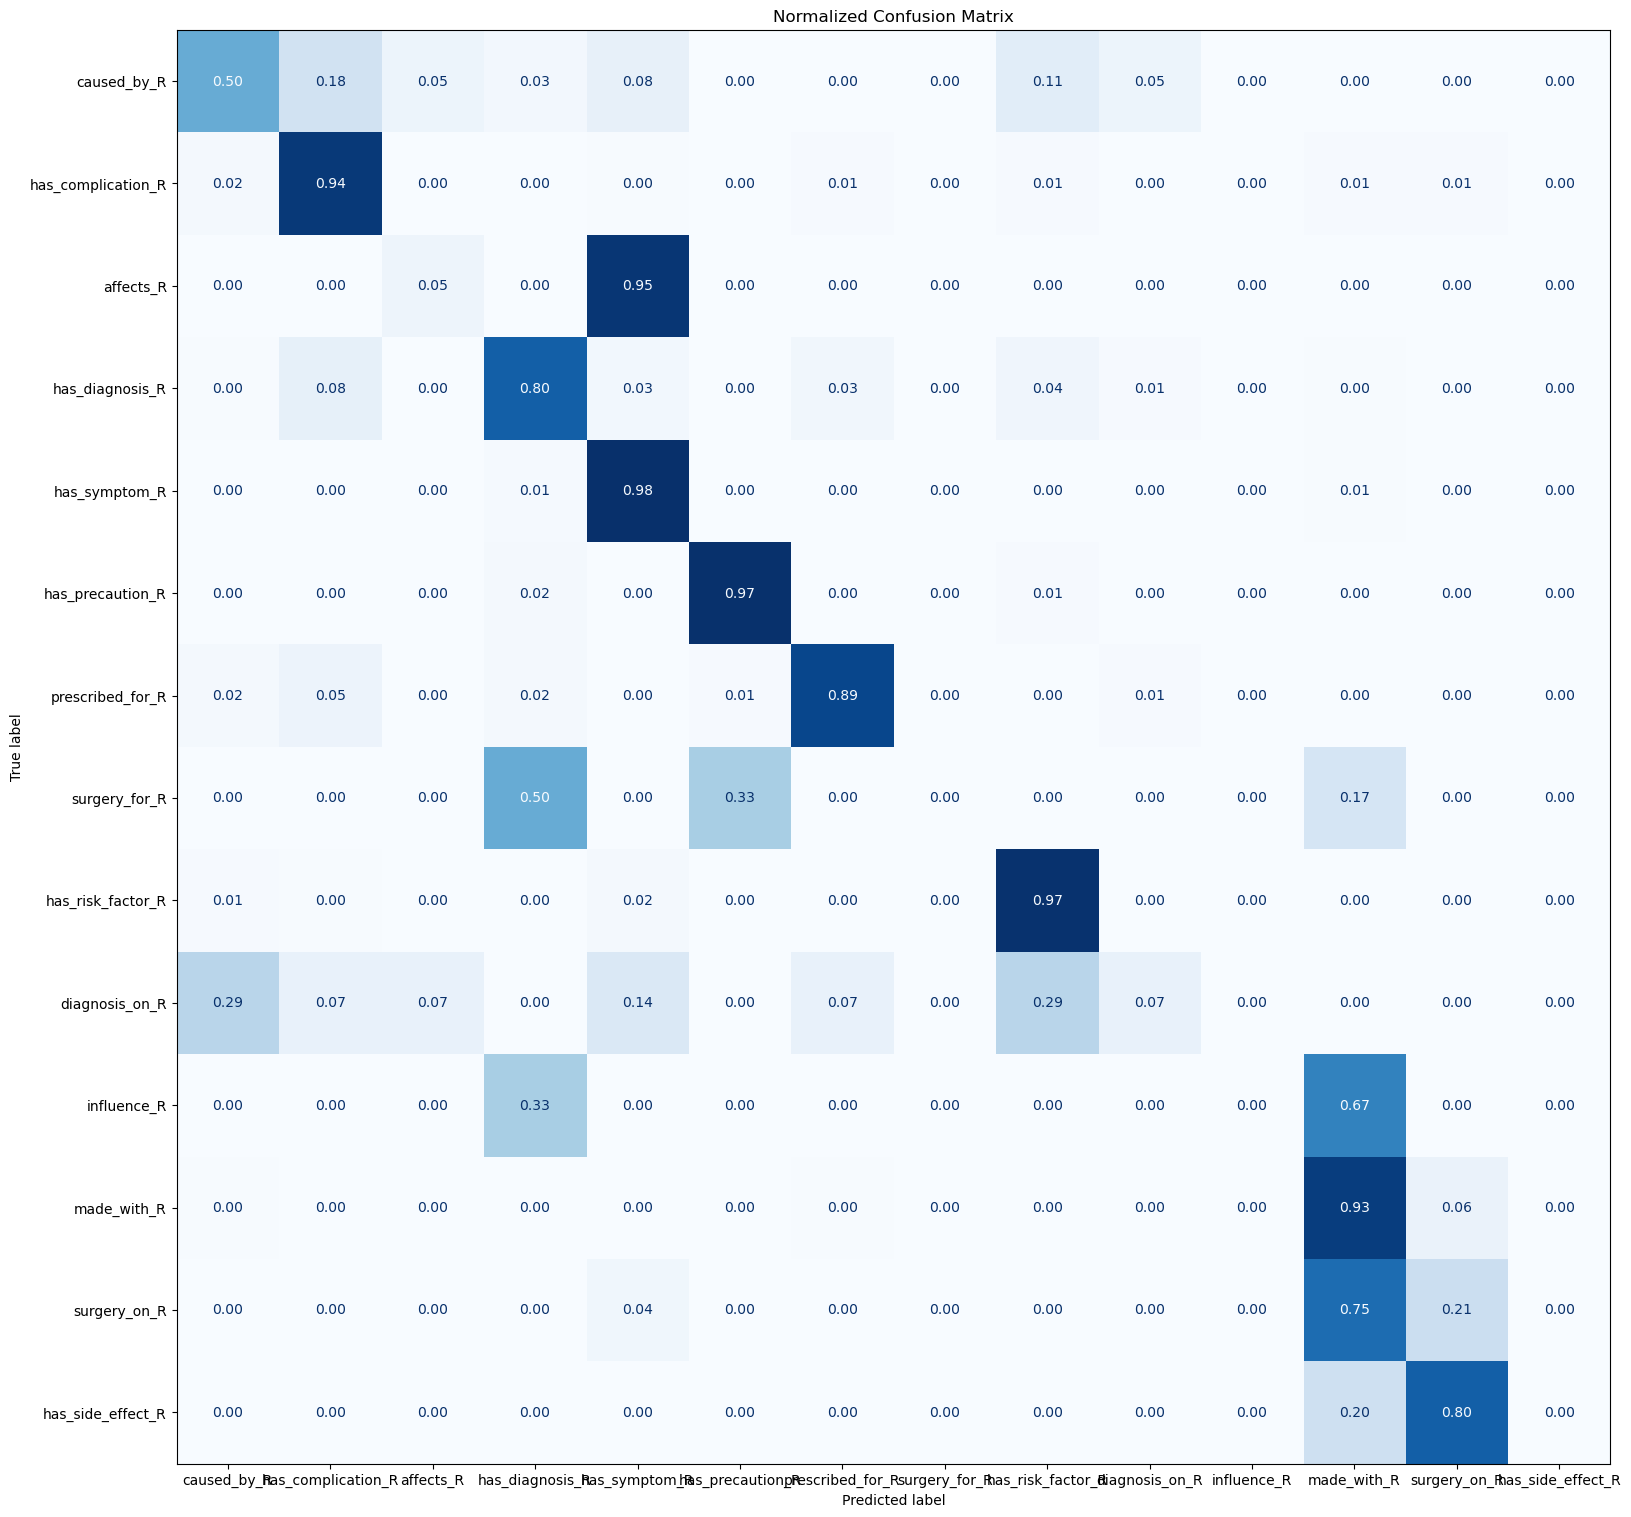

In [37]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(15, 15))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  fig.set_size_inches(18.5, 45)
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, ml)

In [38]:
for batch in train_dl:
    print(batch)
    break

{'input_ids': tensor([[  101,   108,  3291,  8223, 20721,  1116,   118,   141,  6258,  1475,
           174, 18732,  2107,  1475,   172,  8043,  7654,  7903,  1742,  6052,
           117,  8226,   117, 12176,  1137,  3776,  4267,  3202, 15197, 18732,
          2107,  1475,   178, 18732,  2107,  1475, 13280,  1200,   787,   188,
          3653,   117, 22195,   787,   188,  3653,   117,  3177,  1880,  1465,
         23609,  5389, 15105, 18732,  2107,  1475,   187,  6758,   114,   117,
          3799,   118, 23057,  1260, 18732,  2107,  1475, 18732,  2107,  1475,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [39]:
import json

dictionary1 = {
    "text": "Chronic kidney disease, also called chronic kidney failure, involves a gradual loss of kidney function. And its working", 
    "entities": [
        {
            "id": 1,
            "label": "Disease_E",
            "start_offset": 0,
            "end_offset": 22, 
        },
        {
            "id": 2,
            "label": "Complication_E",
            "start_offset": 71,
            "end_offset": 103, 
        },
    ]
}
# dictionary2 = {
#     "text": "Chronic kidney disease occurs when a disease or condition impairs kidney function, causing kidney damage to worsen over several months or years.", 
#     "entities": [
#         {
#             "id": 3,
#             "label": "Disease_E",
#             "start_offset": 0,
#             "end_offset": 22, 
#         },
#         {
#             "id": 4,
#             "label": "Complication_E",
#             "start_offset": 35,
#             "end_offset": 81, 
#         },
#     ]
# }
jsonString = json.dumps(dictionary1, indent=4)
# jsonString += json.dumps(dictionary2, indent=4)
print(jsonString)


{
    "text": "Chronic kidney disease, also called chronic kidney failure, involves a gradual loss of kidney function. And its working",
    "entities": [
        {
            "id": 1,
            "label": "Disease_E",
            "start_offset": 0,
            "end_offset": 22
        },
        {
            "id": 2,
            "label": "Complication_E",
            "start_offset": 71,
            "end_offset": 103
        }
    ]
}


In [51]:
with open("/kaggle/input/updatedre/pred.json", "r") as fin:
    for line in fin:
        print(line)

{"text": "Chronic kidney disease, also called chronic kidney failure, involves a gradual loss of kidney function. And its working.", "entities": [{ "id": 1, "label": "Disease_E", "start_offset": 0, "end_offset": 22}, { "id": 2, "label": "Complication_E", "start_offset": 71, "end_offset": 103} ] } 

{"text": "Chronic kidney disease occurs when a disease or condition impairs kidney function, causing kidney damage to worsen over several months or years.", "entities": [{ "id": 3, "label": "Disease_E", "start_offset": 0, "end_offset": 22}, { "id": 4, "label": "Cause_E", "start_offset": 35, "end_offset": 81} ] } 


In [78]:
id_to_text = {}
start_offset = {}
end_offset = {}
start=0
arr_id = []
entities = {}
fout = open("pred.json", "w")
with open("/kaggle/input/updatedre/pred.json", "r") as fin:
    for line in fin:
#         print(line)
        txt_predict = ""
        rec = json.loads(line.strip())
#         print(rec)
        text = rec["text"]
#         print(text)
        arr = []
        for entity_mention in rec["entities"]:
#           print(entity_mention)
          entity_text = text[entity_mention["start_offset"]:entity_mention["end_offset"]]
          id_to_text[entity_mention["id"]] = entity_text
          arr.append(entity_mention["id"])
          print(entity_mention["id"])
          start_offset[entity_mention["id"]] = entity_mention["start_offset"]
          end_offset[entity_mention["id"]] = entity_mention["end_offset"]

          if entity_mention["label"] == "Composition":
              entity_type = entity_mention["label"][0:3]+"2"
          else:
              entity_type = entity_mention["label"][0:3]+"1"
          entities[entity_text] = entity_type.upper()
          txt_predict += text[start: entity_mention["start_offset"]]
          txt_predict+=entities[entity_text]
          start = entity_mention["end_offset"]
        arr_id.append(arr)
        print(arr)
        txt_predict += text[start:]
        tokens = txt_predict.split()
        output = {
            "tokens": tokens
        }
        print(tokens)
        fout.write(json.dumps(output) + "\n")
        
fout.close()
print(arr_id)

1
2
[1, 2]
['DIS1,', 'also', 'called', 'chronic', 'kidney', 'failure,', 'involves', 'a', 'COM1', 'And', 'its', 'working.']
3
4
[3, 4]
['DIS1', 'occurs', 'when', 'CAU1,', 'causing', 'kidney', 'damage', 'to', 'worsen', 'over', 'several', 'months', 'or', 'years.']
[[1, 2], [3, 4]]


In [81]:
id_to_text[4]

'a disease or condition impairs kidney function'

In [82]:
data_files = os.path.join(DATA_DIR, "pred.json")
print(data_files)
json_pred = load_dataset("json", data_files=data_files)
json_pred

/kaggle/working/pred.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-f06ad5993899f890/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens'],
        num_rows: 2
    })
})

In [83]:
json_pred.set_format(type="pandas")
json_pred_df = json_pred["train"][:]
json_pred_df.head()

,tokens
0,"[DIS1,, also, called, chronic, kidney, failure..."
1,"[DIS1, occurs, when, CAU1,, causing, kidney, d..."


In [84]:
json_pred.reset_format()

In [85]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    
    span_idxs.append([
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0],
      [idx for idx, token in enumerate(tokens) if token.startswith("")][0]
    ])
   
    
  tokenized_inputs["span_idxs"] = span_idxs
#   tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs
encoded = encode_data(json_pred["train"][0:5])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs'])

In [86]:
MAX_LENGTH = 100
encoded_json_dataset_pred = (json_pred
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens"]))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [87]:
pred_dl = DataLoader(encoded_json_dataset_pred["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_json_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)

In [88]:
i=0
ytrue, ypred = [], []
for batch in pred_dl:
#     print(batch)
#     print("----------------- end batch")
    batch = {k: v.to(device) for k, v in batch.items()}
#     print(batch)
#     print("----------------- end batch 2")
    with torch.no_grad():
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
#       print(predictions)
#       print("----------------- predictions")
#       labels = batch["labels"].cpu().numpy()
      print(id_to_text[arr_id[i][0]]," ",id2label[int(np.asarray(predictions))]," ",id_to_text[arr_id[i][1]])
      ytrue.extend(labels)
      ypred.extend(predictions)
    i=i+1

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

Chronic kidney disease   caused_by_R   gradual loss of kidney function.
Chronic kidney disease   has_complication_R   a disease or condition impairs kidney function
test accuracy: 0.500
